In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform


env: XLA_PYTHON_CLIENT_PREALLOCATE=false
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import sys
import jax
jax.config.update("jax_enable_x64", True)
#sys.path.append('../synax/')

import synax,importlib
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import scipy.constants as const

In [3]:
#for debug
def reload_package(package):
    importlib.reload(package)
    for attribute_name in dir(package):
        attribute = getattr(package, attribute_name)
        if type(attribute) == type(package):
            importlib.reload(attribute)
            
reload_package(synax)

In [4]:
nx,ny,nz = 256,256,64

xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
zs = zs + step*0.5

coords = jnp.meshgrid(xs,ys,zs,indexing='ij')
coords[0].shape

tereg = np.load('te.npy')

lsa_params = {"b0":1.2,
               "psi0":27.0*np.pi/180,
               "psi1":0.9*np.pi/180,
               "chi0":25.0*np.pi/180}

simer = synax.synax.Synax()
freq = 2.4
spectral_index = 3.


2024-07-28 16:45:31.661589: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
nside = 64
num_int_points = [2048,1024,512,256]
#num_int_points = [512]
#obtain_vmap = jax.vmap(lambda theta,phi:synax.obtain_positions(theta,phi,num_int_points=num_int_points))
#n_pixs = np.arange(0,12*nside**2)
#theta,phi = hp.pix2ang(nside,n_pixs)
Imap = []
Qmap = []
Umap = []


for num_int_point in num_int_points:
    
    poss,dls,nhats = synax.coords.get_healpix_positions(nside=nside,num_int_points=num_int_point)
    
    C_generator = synax.cfield.C_WMAP(poss)
    C_field = C_generator.C_field()
    
    TE_generator = synax.tefield.TE_grid(poss,(xs,ys,zs))
    TE_field = TE_generator.TE_field(tereg)
    
    B_generator = synax.bfield.B_lsa(poss)
    B_field = B_generator.B_field(lsa_params)
    
    sync = simer.sim(freq,B_field,C_field,TE_field,nhats,dls,spectral_index)
    
    Imap.append(np.array(sync['I']))
    Qmap.append(np.array(sync['Q']))
    Umap.append(np.array(sync['U']))
    
    #del poss,dls,nhats,C_field,C_generator,TE_generator,TE_field,B_generator,B_field,sync
    
    #backend = jax.lib.xla_bridge.get_backend()
    #for buf in backend.live_buffers(): buf.delete()


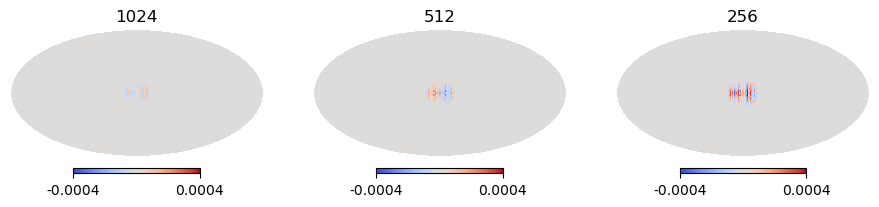

In [6]:
plt.figure(figsize = (15,3))
for i in range(1,4):
    plt.subplot(1,4,i+1)
    hp.mollview(Imap[i] - Imap[0],format='%.2g',cmap='coolwarm',hold=True,title=str(num_int_points[i]),max=0.0004,min=-0.0004)

(1.0, 9900.0)

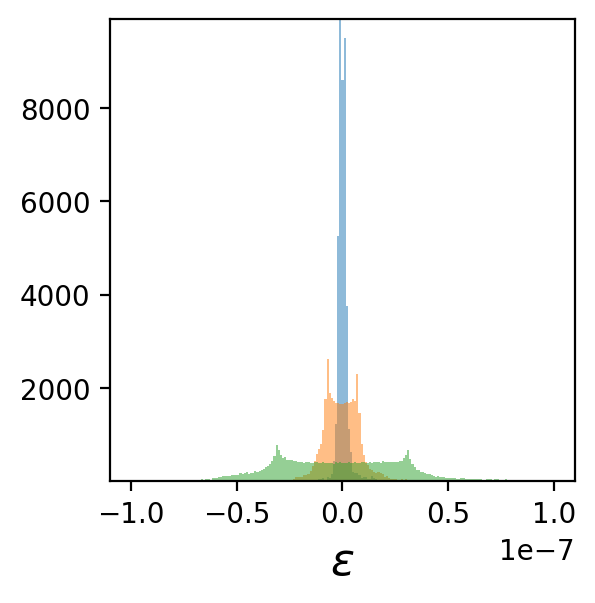

In [7]:
std_I = []
plt.figure(figsize = (3,3),dpi=200)
for i in range(1,4):
    plt.hist(Imap[i] - Imap[0],bins = np.linspace(-0.0000001,0.0000001,200),alpha = 0.5)
    std_I.append(np.std(Imap[i] - Imap[0]))
#plt.semilogy()
plt.xlabel(r'$\epsilon$',fontsize=16)
plt.ylim(1,9900)

Text(0.5, 0, '$\\epsilon$')

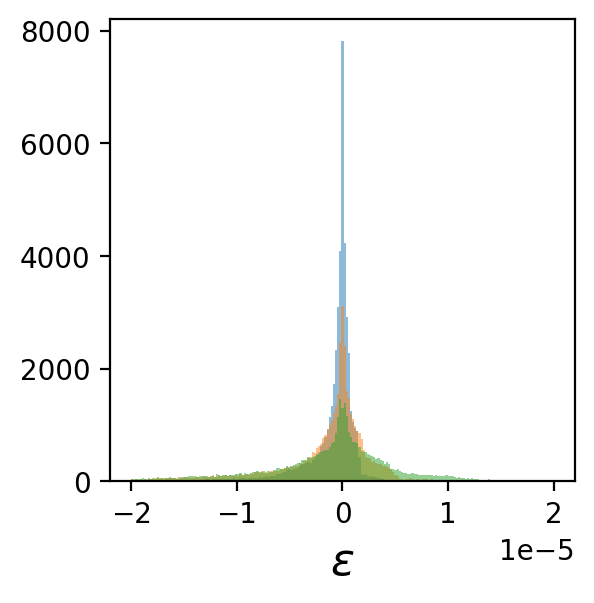

In [8]:
plt.figure(figsize = (3,3),dpi=200)

std_Q=[]
for i in range(1,4):
    plt.hist(Qmap[i] - Qmap[0],bins = np.linspace(-0.00002,0.00002,200),alpha = 0.5)
    std_Q.append(np.std(Qmap[i] - Qmap[0]))
#plt.semilogy()
plt.xlabel(r'$\epsilon$',fontsize=16)

Text(0.5, 0, '$\\epsilon$')

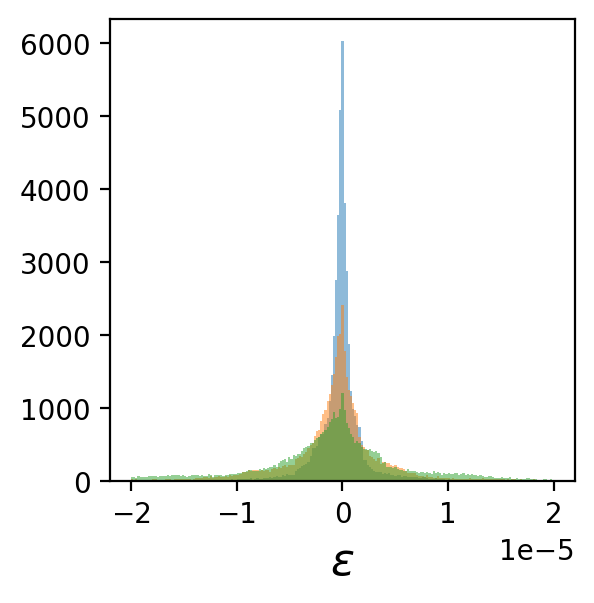

In [9]:
plt.figure(figsize = (3,3),dpi=200)
std_U = []
for i in range(1,4):
    plt.hist(Umap[i] - Umap[0],bins = np.linspace(-0.00002,0.00002,200),alpha = 0.5)
    std_U.append(np.std(Umap[i] - Umap[0]))
#plt.semilogy()
plt.xlabel(r'$\epsilon$',fontsize=16)

In [10]:
((28.3**2+20**2+5**2)**0.5)/2048

0.01709605077012859

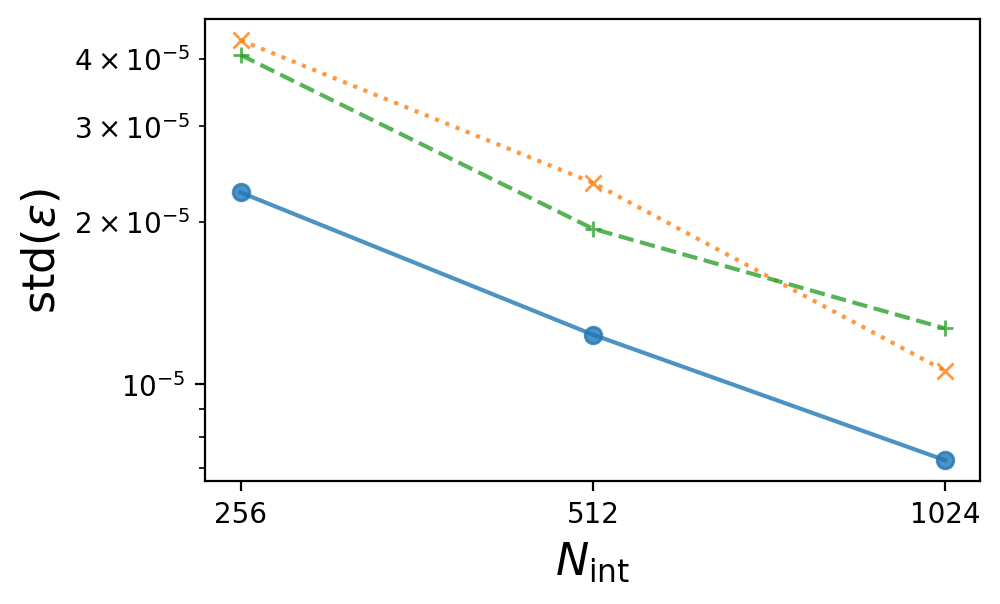

In [15]:
resolution = [256,512,1024]
plt.figure(figsize=(5,3),dpi=200)
plt.semilogy(list(reversed(std_I)),marker = 'o',alpha = 0.8)
plt.semilogy(list(reversed(std_Q)),marker = 'x',alpha = 0.8,linestyle = ':')
plt.semilogy(list(reversed(std_U)),marker = '+',alpha = 0.8,linestyle = '--')

plt.xticks([0,1,2,],['256','512','1024',])

plt.ylabel(r'std$(\epsilon)$',fontsize=16)
plt.xlabel(r'$N_{\rm int}$',fontsize=16)
#plt.legend(['I','Q','U'])
plt.savefig('../figures/int_error.pdf',bbox_inches='tight')

In [19]:
nside = 64
num_grid_points = [64,128,256,512]
#obtain_vmap = jax.vmap(lambda theta,phi:synax.obtain_positions(theta,phi,num_int_points=num_int_points))
#n_pixs = np.arange(0,12*nside**2)
#theta,phi = hp.pix2ang(nside,n_pixs)
Imap_grid = []
Qmap_grid = []
Umap_grid = []

poss,dls,nhats = synax.coords.get_healpix_positions(nside=nside,num_int_points=512)
    
C_generator = synax.cfield.C_WMAP(poss)
C_field = C_generator.C_field()

TE_generator = synax.tefield.TE_grid(poss,(xs,ys,zs))
TE_field = TE_generator.TE_field(tereg)


for num_grid_point in num_grid_points:
    
    nx,ny,nz = num_grid_point,num_grid_point,int(num_grid_point/4)

    xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
    xs = xs + step*0.5

    ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
    ys = ys + step*0.5

    zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
    zs = zs + step*0.5

    coords = jnp.meshgrid(xs,ys,zs,indexing='ij')
    
    B_grid_generator = synax.bfield.B_lsa(coords)
    B_grid = B_grid_generator.B_field(lsa_params)
    
    B_generator = synax.bfield.B_grid(poss,(xs,ys,zs))
    B_field = B_generator.B_field(B_grid)
    
    sync = simer.sim(freq,B_field,C_field,TE_field,nhats,dls,spectral_index)
    
    Imap_grid.append(np.array(sync['I']))
    Qmap_grid.append(np.array(sync['Q']))
    Umap_grid.append(np.array(sync['U']))
    
    #del poss,dls,nhats,C_field,C_generator,TE_generator,TE_field,B_generator,B_field,sync
    
    #backend = jax.lib.xla_bridge.get_backend()
    #for buf in backend.live_buffers(): buf.delete()

In [14]:
backend = jax.lib.xla_bridge.get_backend()
for buf in backend.live_buffers(): buf.delete()

In [23]:
std_I = []
std_Q = []
std_U = []

for i in range(4):
    std_I.append(np.std(Imap_grid[i] - Imap[0]))
    std_Q.append(np.std(Qmap_grid[i] - Qmap[0]))
    std_U.append(np.std(Umap_grid[i] - Umap[0]))
#plt.semilogy()

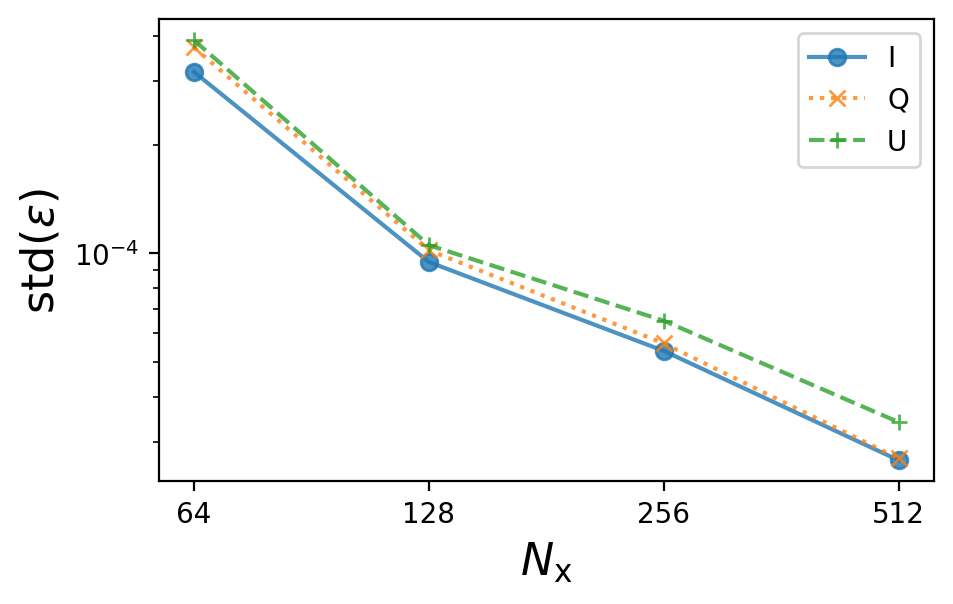

In [33]:
resolution = [64,128,256,512]
plt.figure(figsize=(5,3),dpi=200)
plt.semilogy(std_I,marker = 'o',alpha = 0.8)
plt.semilogy(std_Q,marker = 'x',alpha = 0.8,linestyle = ':')
plt.semilogy(std_U,marker = '+',alpha = 0.8,linestyle = '--')

plt.xticks([0,1,2,3,],['64','128','256','512'])

plt.ylabel(r'std$(\epsilon)$',fontsize=16)
plt.xlabel(r'$N_{\rm x}$',fontsize=16)

plt.legend(['I','Q','U'])

#plt.savefig('../figures/grid_error.pdf',bbox_inches='tight')

In [5]:
nside = 128
num_int_points = 512
#num_int_points = [512]
#obtain_vmap = jax.vmap(lambda theta,phi:synax.obtain_positions(theta,phi,num_int_points=num_int_points))
#n_pixs = np.arange(0,12*nside**2)
#theta,phi = hp.pix2ang(nside,n_pixs)
Imap = []
Qmap = []
Umap = []

    
poss,dls,nhats = synax.coords.get_healpix_positions(nside=nside,num_int_points=num_int_points)
    
C_generator = synax.cfield.C_WMAP(poss)

    
TE_generator = synax.tefield.TE_grid(poss,(xs,ys,zs))

    
B_generator = synax.bfield.B_lsa(poss)    


In [7]:
%time C_field = C_generator.C_field()
%time TE_field = TE_generator.TE_field(tereg)
%time B_field = B_generator.B_field(lsa_params)
%time sync = simer.sim(freq,B_field,C_field,TE_field,nhats,dls,spectral_index)

CPU times: user 9.03 ms, sys: 0 ns, total: 9.03 ms
Wall time: 7.24 ms
CPU times: user 141 ms, sys: 181 ms, total: 322 ms
Wall time: 368 ms
CPU times: user 15.2 ms, sys: 4.44 ms, total: 19.6 ms
Wall time: 20.6 ms
CPU times: user 16.8 ms, sys: 5.87 ms, total: 22.7 ms
Wall time: 22.4 ms


In [3]:
t_2048 = 13.7+377+19+20.9
t_1024 = 8.88+85.7+12.4+14.6
t_512 = 2.73+46+6.58+7.92
t_256 = 1.41+25.3+4.37+4.62

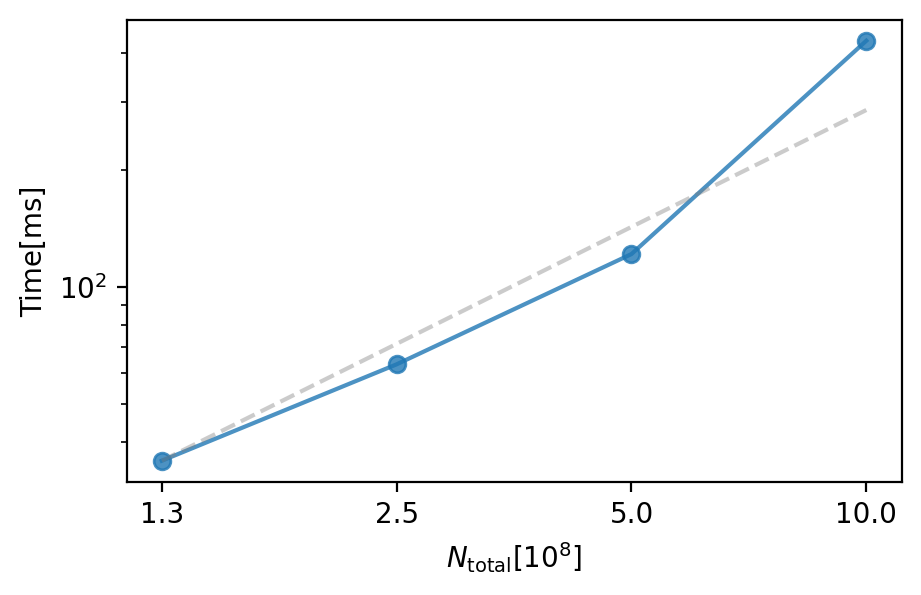

In [4]:
plt.figure(figsize=(5,3),dpi=200)
plt.semilogy([t_256,t_512,t_1024,t_2048],marker='o',alpha=0.8)
plt.semilogy([t_256,t_256*2,t_256*4,t_256*8],color='tab:gray',alpha=0.4,linestyle='--')
plt.ylabel('Time[ms]')
plt.xticks([0,1,2,3],['1.3','2.5','5.0','10.0'])
plt.xlabel(r'$N_{\rm total}$[$10^8$]')
plt.savefig('../figures/runtime.pdf',bbox_inches='tight')

In [ ]:
t_64 = 2.73+46+6.58+7.92
t_128 = 7.24+368+20.6+22.4